# Deep Learning for Sentiment Analysis on the Yelp Dataset

## Imports

In [ ]:
# just to make sure that all libraries are available
%pip install tensorflow matplotlib pandas folium kaggle scikit-learn seaborn 


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


: 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import os
import math

## Get data from Kaggle

In [4]:
os.environ['KAGGLE_USERNAME'] = "x"
os.environ['KAGGLE_KEY'] = "x"

In [5]:
!kaggle datasets download -d yelp-dataset/yelp-dataset

401 - Unauthorized


In [67]:
!mkdir yelp-data 2>/dev/null && unzip -d yelp-data yelp-dataset.zip || echo "Data is already prepared"

Data is already prepared


## Examine and plot it

In [6]:
data_dir = "yelp-data/" # splitting data up like this might be useful for later (in case i want to use other files)
target_file = "yelp_academic_dataset_review.json"

In [7]:
data_file = data_dir + target_file

In [8]:
def read_to_dataframe(data_file, max_nl = 100_000):
  data = []
  with open(data_file) as f:
    nl = 0
  
    for line in f:
      data.append(json.loads(line))
    
      nl += 1
      if nl >= max_nl:
        break

  return pd.DataFrame(data)

In [12]:
data_df = read_to_dataframe(data_file)

In [7]:
data_df.head() # to get an idea as to what we're dealing with

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [8]:
data_df.info() # all entries are non-null! 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review_id    100000 non-null  object 
 1   user_id      100000 non-null  object 
 2   business_id  100000 non-null  object 
 3   stars        100000 non-null  float64
 4   useful       100000 non-null  int64  
 5   funny        100000 non-null  int64  
 6   cool         100000 non-null  int64  
 7   text         100000 non-null  object 
 8   date         100000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 6.9+ MB


In [13]:
data_df.describe()

,stars,useful,funny,cool
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,3.842910,0.898980,0.257180,0.347030
std,1.354729,2.205186,1.010212,1.066382
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,0.000000
max,5.000000,320.000000,98.000000,49.000000


I don't particularly like the identifiers used in this dataframe, so I'll join this data with the data containing additional information about them so that we get much more meaningful and human-friendly data.

In [9]:
business_file = "yelp_academic_dataset_business.json"

business_df = read_to_dataframe(data_dir + business_file, max_nl=math.inf) # no need to set a limit (the file is 113MB large)
business_df.drop(["stars"], axis=1, inplace=True) # this is the rating of the businesses (we don't care about that)

In [13]:
rich_data = pd.merge(data_df, business_df, on="business_id")

In [10]:
rich_data.head() # as we can see, we now have a richer dataset, which makes it easier to identify the businesses (as far as the reviews and the users are concerned, it's not important to further enrich the data)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name,...,city,state,postal_code,latitude,longitude,review_count,is_open,attributes,categories,hours
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,...,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
1,VJxlBnJmCDIy8DFG0kjSow,Iaee7y6zdSB3B-kRCo4z1w,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,0,0,0,This is the second time we tried turning point...,2017-05-13 17:06:55,Turning Point of North Wales,...,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
2,S6pQZQocMB1WHMjTRbt77A,ejFxLGqQcWNLdNByJlIhnQ,XQfwVwDr-v0ZS3_CbbE5Xw,4.0,2,0,1,The place is cute and the staff was very frien...,2017-08-08 00:58:18,Turning Point of North Wales,...,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
3,WqgTKVqWVHDHjnjEsBvUgg,f7xa0p_1V9lx53iIGN5Sug,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,We came on a Saturday morning after waiting a ...,2017-11-19 02:20:23,Turning Point of North Wales,...,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
4,M0wzFFb7pefOPcxeRVbLag,dCooFVCk8M1nVaQqcfTL3Q,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,0,0,0,"Mediocre at best. The decor is very nice, and ...",2017-09-09 17:49:47,Turning Point of North Wales,...,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."


For a much cooler visualization, we can use the folium library!

In [ ]:
import folium

fol_fig = folium.Figure(width=1000, height=600)

# Create a map object centered at a specific location (e.g., the geographical center of North America (we know the data is from USA and Canada))
map_obj = folium.Map(location=[39.7392, -104.9903], zoom_start=4, tiles='Stamen Toner').add_to(fol_fig)

sampled_df = rich_data.sample(n=1000) # to speed up execution (up to 1000 works fine, above that it starts to slow down significantly)
# Iterate over your dataset and add markers for each data point
for index, row in sampled_df.iterrows():
    # Extract the latitude and longtude values from your dataframe
    latitude = row['latitude']
    longitude = row['longitude']
    
    # Add a marker to the map for each data point
    folium.Marker([latitude, longitude]).add_to(map_obj)

# Display the map
map_obj

## Prepare the data 

### Let's define some useful functions

In [3]:
def prepare_for_model(train_dataset, m, val_dataset, test_dataset, preprocess_fn, batch_size=64):
    # Apply the preprocessing pipeline to the datasets
    train_dataset_prepepared = train_dataset.map(
        lambda review, label: (preprocess_fn(review), label))
    val_dataset_prepared = val_dataset.map(
        lambda review, label: (preprocess_fn(review), label))
    test_dataset_prepared = test_dataset.map(
        lambda review, label: (preprocess_fn(review), label))

    # Shuffle and batch the training dataset
    train_dataset_prepepared = train_dataset_prepepared.shuffle(m).batch(batch_size)

    # Batch the validation and testing datasets
    val_dataset_prepared = val_dataset_prepared.batch(batch_size)
    test_dataset_prepared = test_dataset_prepared.batch(batch_size)

    return train_dataset_prepepared, val_dataset_prepared, test_dataset_prepared

def create_datasets(feature_columns, label_column, train_size, test_size, random_state=None):
    X = rich_data[feature_columns]
    y = rich_data[label_column]

    # Split the dataset into training (70%), validation (15%), and testing (15%) sets
    X_train, X_test_val, y_train, y_test_val = train_test_split(
        X, y, train_size=train_size, stratify=y, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(
        X_test_val, y_test_val, test_size=test_size, stratify=y_test_val, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

### And some useful hyperparameters

In [4]:
vocabulary_size = 30_000
random_state = 42 # for reproducibility
train_size = 0.7 # the percentage of data reserved for training
test_size = 0.5 # the percentage of data reserved for testing (from the data that remains)
n_epochs = 10 # adjust this if the model trains too slowly (or modify model parameters as desired...)

### Ok, now on to data preparation

In [65]:
X_train, X_val, X_test, y_train, y_val, y_test = create_datasets(
    'text', 'stars', train_size, test_size, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (70000,) (70000,)
Validation set shape: (15000,) (15000,)
Testing set shape: (15000,) (15000,)


In [68]:
# Create TensorFlow datasets for the training, validatoin and test data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [69]:
# we have the very convenient TextVectorizatoin layer for preprocessing which takes care of everything from standardization to vectorization!
text_vectorization = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode='multi_hot',
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    # the option below is only useful if output_mode is "int" (it takes care of the padding)
    # output_sequence_length=max_length,
)

In [72]:
text_vectorization.adapt(train_dataset.map(lambda review, label: review)) # build the vocabulary (might take a while...)

In [73]:
train_dataset_prep, val_dataset_prep, test_dataset_prep = prepare_for_model(
    train_dataset, len(X_train), val_dataset, test_dataset, text_vectorization)

Let's take a look at the data!

In [17]:
for inputs, targets in train_dataset_prep:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)

    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)

    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

2023-06-11 16:15:59.363306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 44136 of 70000
2023-06-11 16:16:05.048983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


inputs.shape: (64, 30000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (64,)
targets.dtype: <dtype: 'float64'>
inputs[0]: tf.Tensor([0. 1. 1. ... 0. 0. 0.], shape=(30000,), dtype=float32)
targets[0]: tf.Tensor(3.0, shape=(), dtype=float64)


## Let's try a Bag-of-Words approach 

Let's try a simple 1-gram bag-of-words model first:

In [74]:
def create_bow_model(input_dim):
    input = tf.keras.Input(shape=(input_dim,))

    x = layers.Dense(256, activation='relu')(input)  # Dense layer with 32 neurons
    x = layers.Dropout(0.5)(x)  # Dropout layer with rate 0.5
    x = layers.Dense(256, activation='relu')(x)  # Dense layer with 16 neurons
    x = layers.Dropout(0.5)(x)  # Dropout layer with rate 0.5
    x = layers.Dense(128, activation='relu')(x)  # Dense layer with 16 neurons
    x = layers.Dropout(0.5)(x)  # Dropout layer with rate 0.5
    x = layers.Dense(64, activation='relu')(x)  # Dense layer with 16 neurons
    x = layers.Dropout(0.5)(x)  # Dropout layer with rate 0.5
    x = layers.Dense(64, activation='relu')(x)  # Dense layer with 16 neurons
    x = layers.Dropout(0.5)(x)  # Dropout layer with rate 0.5

    output = layers.Dense(1)(x)  # Output layer with a single neuron (regression)

    model = tf.keras.Model(inputs=input, outputs=output)

    # Compile the model with mean squared error (MSE) loss for regression
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    return model

In [ ]:
def fit_model(model, train_data, validation_data, n_epochs, verbose=0):
    # TODO add a callback to save the model so we don't have to train it over and over again
    history = model.fit(
        train_data.cache(),
        validation_data=validation_data.cache(),
        epochs=n_epochs, # adjust this parameter if the training is too slow
        # set to 0 because of https://stackoverflow.com/questions/41442276/keras-verbose-training-progress-bar-writing-a-new-line-on-each-batch-issue
        verbose=verbose,
    )

    return history

In [ ]:
def plot_training_curves(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

In [75]:
model_1gram = create_bow_model(vocabulary_size)

In [ ]:
model_1gram.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense_30 (Dense)            (None, 256)               7680256   
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_31 (Dense)            (None, 256)               65792     
                                                                 
 dropout_26 (Dropout)        (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 128)               32896     
                                                                 
 dropout_27 (Dropout)        (None, 128)               0   

In [78]:
# TODO add a boolean to check whether we wish to train this model or not, if not look for it locally
history_1gram = fit_model(
    model_1gram, train_dataset_prep, val_dataset_prep, n_epochs)

2023-06-12 17:54:12.282428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 43114 of 70000
2023-06-12 17:54:18.371039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


KeyboardInterrupt: 

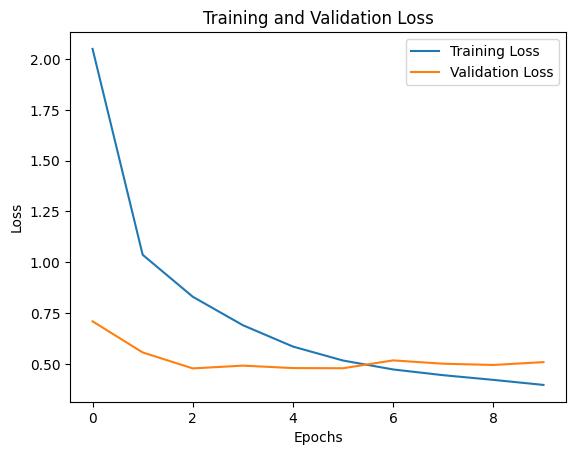

In [93]:
plot_training_curves(history_1gram)

Let's experiment with a 2-gram model!

In [64]:
# we have the very convenient TextVectorizatoin layer for preprocessing!
text_vectorization = layers.TextVectorization(
    ngrams=2, # it's that simple!
    max_tokens=vocabulary_size,
    output_mode='multi_hot',
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    # the option below is only useful if output_mode is "int" (it takes care of the padding)
    # output_sequence_length=max_length,
)

In [66]:
text_vectorization.adapt(train_dataset.map(lambda review, label: review)) # build the vocabulary (might take a while...)

In [70]:
model_2gram = create_bow_model(vocabulary_size)

In [92]:
model_2gram.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense_24 (Dense)            (None, 256)               7680256   
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               65792     
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0   

In [71]:
# we're going to train on the exact same model! (to check whether using 2grams actually makes a difference)
history_2gram = fit_model(
    model_2gram, train_dataset_prep, val_dataset_prep, n_epochs)















2023-06-09 18:57:41.128128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 39448 of 69997
2023-06-09 18:57:48.767068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.



























































































































































































































































































































































































































































































































































































































































2023-06-09 18:58:20.558586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Fill

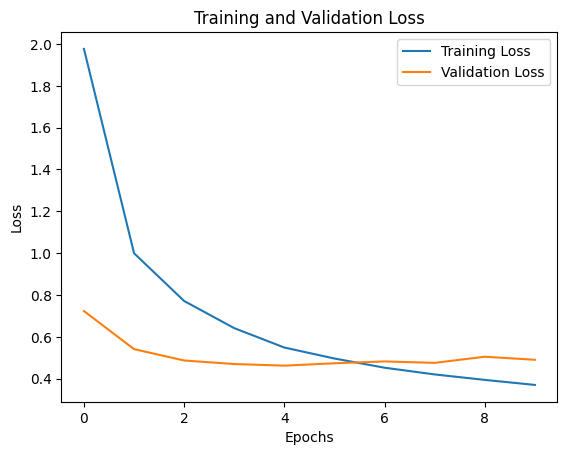

In [84]:
plot_training_curves(history_2gram)

They look quite similar.

In [96]:
# Evaluate model 1
loss_1, mse_1= model_1gram.evaluate(test_dataset_prep)
print(f"Model 1 - Test Loss: {loss_1:.4f}, MSE: {mse_1:.4f}")

# Evaluate model 2
loss_2, mse_2 = model_2gram.evaluate(test_dataset_prep)
print(f"Model 2 - Test Loss: {loss_2:.4f}, MSE: {mse_2:.4f}")


235/235 [==============================] - 5s 20ms/step - loss: 0.5093 - mse: 0.5093
Model 1 - Test Loss: 0.5093, MSE: 0.5093
235/235 [==============================] - 5s 19ms/step - loss: 0.4867 - mse: 0.4867
Model 2 - Test Loss: 0.4867, MSE: 0.4867


The 2-gram model is a bit better at evaluation time. Hurray!

In [19]:
# we have the very convenient TextVectorizatoin layer for preprocessing!
text_vectorization = layers.TextVectorization(
    ngrams=2,
    max_tokens=vocabulary_size,
    output_mode='tf_idf', # once again, it's that simple
    standardize="lower_and_strip_punctuation",
    split="whitespace",
)

In [20]:
text_vectorization.adapt(train_dataset.map(lambda review, label: review)) # build the vocabulary (might take a while...)

In [23]:
model_tfidf = create_model(vocabulary_size)

In [24]:
model_tfidf.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense (Dense)               (None, 256)               7680256   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0     

In [27]:
history_tfidf = fit_model(
    model_tfidf, train_dataset_prep, val_dataset_prep, n_epochs)







2023-06-11 16:33:50.839756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 40467 of 70000
2023-06-11 16:33:58.102559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.































































































































































































































































































































2023-06-11 16:34:31.145198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42002 of 70000
2023-06-11 16:34:37.920676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.



























































































































































In [28]:
# Evaluate the TF-IDF model
loss_tfidf, mse_tfidf = model_tfidf.evaluate(test_dataset_prep)
print(f"Model 2 - Test Loss: {loss_tfidf:.4f}, MSE: {mse_tfidf:.4f}")

235/235 [==============================] - 5s 22ms/step - loss: 0.5073 - mse: 0.5073
Model 2 - Test Loss: 0.5073, MSE: 0.5073


It seems that TF-IDF doesn't change much.

## So far we've only used textual data, why don't we use the rest?

In [29]:
rich_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   review_id     100000 non-null  object 
 1   user_id       100000 non-null  object 
 2   business_id   100000 non-null  object 
 3   stars         100000 non-null  float64
 4   useful        100000 non-null  int64  
 5   funny         100000 non-null  int64  
 6   cool          100000 non-null  int64  
 7   text          100000 non-null  object 
 8   date          100000 non-null  object 
 9   name          100000 non-null  object 
 10  address       100000 non-null  object 
 11  city          100000 non-null  object 
 12  state         100000 non-null  object 
 13  postal_code   100000 non-null  object 
 14  latitude      100000 non-null  float64
 15  longitude     100000 non-null  float64
 16  review_count  100000 non-null  int64  
 17  is_open       100000 non-null  int64  
 18  attri

We have plenty of information, but a lot of it is useless/confounding.
 - the 'useful', 'funny' and 'cool' columns contain information about the review itself, i.e. they're obtained posterior to the stars, so we should remove them (also, check out the correlation matrix below: it's clear they matter very little)
 - the 'date' column should be eliminated to remove spurious correlations (there might be a relationship between date and stars, but it's definitely not one we want to learn, it smells of overfitting)
 - the 'name', 'address', 'city', 'state' and 'postal_code' columns should be eliminated because their information is contained in the latitude and longitude columns, so they're redundant
 - the 'is_open' column could be useful as a filtering step (i.e. we might only want to perform sentiment analysis on open businesses), but for simplification I'll drop it
 - the 'categories' column could also used as a filtering step (as it is on Kaggle, e.g. https://www.kaggle.com/code/niyamatalmass/finding-the-perfect-restaurants-on-yelp), but for simplification I'll drop it
 - the 'hours' column is as above, so I'll drop it as well

 At the end of the day we only provisionally keep the 'text', 'latitude', 'longitude', 'review_count' and 'attributes' columns for our features (and, clearly, the 'stars' column as labels)...

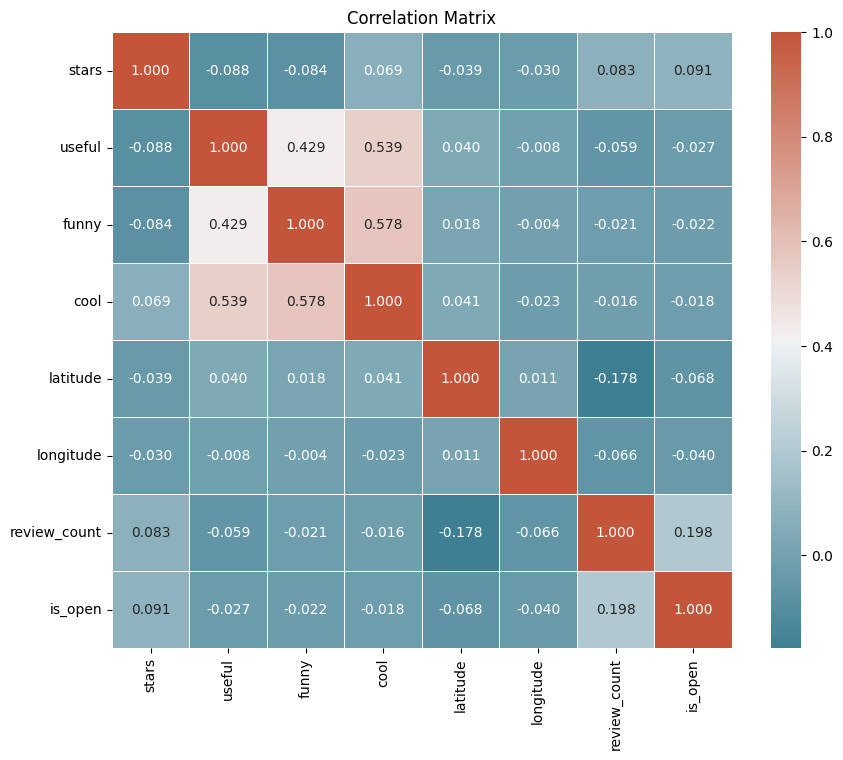

In [59]:
# compute the correlation matrix of the various numerical attributes
numeric_columns = rich_data.select_dtypes(include=['int64', 'float64'])
# Assuming your DataFrame is named 'df'
corr_matrix = numeric_columns.corr()

# Set the color palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plot the correlation matrix with highlighted 'stars' column
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap=cmap, annot=True, fmt=".3f", linewidths=0.5, cbar=True)
plt.title("Correlation Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


It seems like the review_count, latitude and longitude columns are not that significant... Let's check it with a scatter plot.

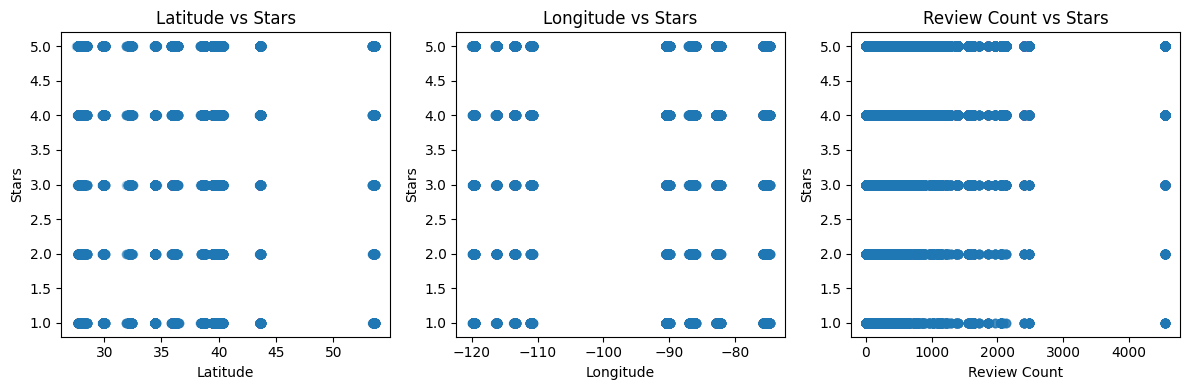

In [18]:
# Create a scatter plot for latitude vs stars
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(rich_data['latitude'], rich_data['stars'], alpha=0.3)
plt.xlabel('Latitude')
plt.ylabel('Stars')
plt.title('Latitude vs Stars')

# Create a scatter plot for longitude vs stars
plt.subplot(132)
plt.scatter(rich_data['longitude'], rich_data['stars'], alpha=0.3)
plt.xlabel('Longitude')
plt.ylabel('Stars')
plt.title('Longitude vs Stars')

# Create a scatter plot for review_count vs stars
plt.subplot(133)
plt.scatter(rich_data['review_count'], rich_data['stars'], alpha=0.3)
plt.xlabel('Review Count')
plt.ylabel('Stars')
plt.title('Review Count vs Stars')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

# => they all seem to not matter much at all (as hinted at by the correlation matrix)

In [38]:
X = rich_data[['text', 'attributes']]
y = rich_data['stars']

In [39]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        100000 non-null  object
 1   attributes  98369 non-null   object
dtypes: object(2)
memory usage: 1.5+ MB


The 'attributes' column looks extremely interesting to me, and I already have an interesting idea as to how to use it (i.e. learn some embeddings based on its contents and substitute the column with these embeddings). But, to avoid useless work, it's a good idea to try to estimate its importance, or at least its viability in our context.

In [40]:
# it contains JSON objects, it seems, with two level of nesting and all attributes are textual (i.e. categorical)
X.iloc[0].attributes

{'NoiseLevel': "u'average'",
 'HasTV': 'False',
 'RestaurantsAttire': "'casual'",
 'BikeParking': 'False',
 'Ambience': "{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': True}",
 'WiFi': "'free'",
 'DogsAllowed': 'False',
 'Alcohol': "'none'",
 'BusinessAcceptsCreditCards': 'True',
 'RestaurantsGoodForGroups': 'True',
 'RestaurantsPriceRange2': '2',
 'RestaurantsReservations': 'False',
 'WheelchairAccessible': 'True',
 'BusinessAcceptsBitcoin': 'False',
 'RestaurantsTableService': 'True',
 'GoodForKids': 'True',
 'Caters': 'False',
 'HappyHour': 'False',
 'RestaurantsDelivery': 'True',
 'GoodForMeal': "{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': False, 'brunch': True, 'breakfast': True}",
 'OutdoorSeating': 'True',
 'RestaurantsTakeOut': 'True',
 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}"}

In [41]:
# let's try to flatten the column and see what we're working with...
def flatten_json_columns(df, columns):
    for col in columns:
        df_normalized = pd.json_normalize(df[col])
        df = df.drop(columns=[col])
        df = pd.concat([df, df_normalized], axis=1)
    return df

# Assuming 'df' is your pandas DataFrame
# First level of normalization on 'attributes' column
X = flatten_json_columns(X, ['attributes'])

# Second level of normalization on nested columns
X = flatten_json_columns(
    X, ['Ambience', 'GoodForMeal', 'BusinessParking'])

In [42]:
# that added a LOT of new columns, and most of them containing plenty of nulls (i.e. check out the RestaurantsCounterService column!)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   text                        100000 non-null  object
 1   NoiseLevel                  73115 non-null   object
 2   HasTV                       72629 non-null   object
 3   RestaurantsAttire           70807 non-null   object
 4   BikeParking                 83583 non-null   object
 5   WiFi                        80187 non-null   object
 6   DogsAllowed                 42427 non-null   object
 7   Alcohol                     73054 non-null   object
 8   BusinessAcceptsCreditCards  94663 non-null   object
 9   RestaurantsGoodForGroups    72738 non-null   object
 10  RestaurantsPriceRange2      90112 non-null   object
 11  RestaurantsReservations     72372 non-null   object
 12  WheelchairAccessible        36623 non-null   object
 13  BusinessAcceptsBitcoin      21

In [46]:
null_counts = X.isnull().sum()
sorted_columns = null_counts.sort_values() # sort columns based on number of null values in each

X[sorted_columns.index].info() # by the 18th column we're already at 60% of values being null!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   text                        100000 non-null  object
 1   BusinessAcceptsCreditCards  94663 non-null   object
 2   RestaurantsPriceRange2      90112 non-null   object
 3   BikeParking                 83583 non-null   object
 4   WiFi                        80187 non-null   object
 5   GoodForKids                 77828 non-null   object
 6   RestaurantsTakeOut          77366 non-null   object
 7   RestaurantsDelivery         75632 non-null   object
 8   OutdoorSeating              74694 non-null   object
 9   NoiseLevel                  73115 non-null   object
 10  Alcohol                     73054 non-null   object
 11  RestaurantsGoodForGroups    72738 non-null   object
 12  HasTV                       72629 non-null   object
 13  RestaurantsReservations     72

At this point we have two choices: we either leave the attributes in (and preprocess them, embed them, etc. as specified above) or we dont. I'll opt for the second choice because 1. I don't have access to a lot of compute and training embeddings could be quite compute intensive 2. Intuitively speaking, a lot of this information should be in the review text itself, so the model probably already takes that into account when trying to predict a rating. So? It seems our initial approach of only utilising the text was a reasonable one and that no further feature engineering is necessary.

This is comforting and also more interesting: using only the text makes the problem more challenging and has a good change of improving out-of-distribution performance anyhow, because we literally have no other variables to think about!

## Time to get serious: let's use RNNs!

### Let's quickly go through the data preparation steps (all explained above)...

In [15]:
X_train, X_val, X_test, y_train, y_val, y_test = create_datasets(
    'text', 'stars', train_size, test_size, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Create TensorFlow datasets for the training, validatoin and test data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

max_length = max(rich_data['text'].apply(lambda x: len(x.split())))

text_vectorization = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode="int",
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_sequence_length=max_length,
)

text_vectorization.adapt(train_dataset.map(lambda review, label: review)) # build the vocabulary (might take a while...)

train_dataset_prep, val_dataset_prep, test_dataset_prep = prepare_for_model(
    train_dataset, len(X_train), val_dataset, test_dataset, text_vectorization)

Training set shape: (70000,) (70000,)
Validation set shape: (15000,) (15000,)
Testing set shape: (15000,) (15000,)


### On to defining our models and training them...

In [45]:
# we expect to benefit from an RNN based model because the improvement we saw with 2-grams indicates that the local structure is important!
def create_LSTM_model(max_length, num_words):
    inputs = layers.Input(shape=(max_length,), dtype="int64")
    one_hot = tf.one_hot(inputs, depth=num_words)

    lstm = layers.Bidirectional(layers.LSTM(32))(one_hot)
    outputs = layers.Dense(1)(lstm)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mse'])
    
    return model

In [56]:
lstm_model = create_LSTM_model(max_length, vocabulary_size)

In [47]:
lstm_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1006)]            0         
                                                                 
 tf.one_hot_7 (TFOpLambda)   (None, 1006, 30000)       0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 64)                7688448   
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7688513 (29.33 MB)
Trainable params: 7688513 (29.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]

# so this takes A LOT longer...
history = lstm_model.fit(
    train_dataset_prep,
    validation_data=val_dataset_prep, 
    epochs=5,
    callbacks=callbacks)

Epoch 1/5


KeyboardInterrupt: 

Training a bidirectional LSTM model (even one as simple as the one we created) takes much, much more time thant it does for the fully connected FFN above... There's one hope though, suggested to us by Chollet in his DL book: we could achieve a similar effect using Conv1D layers! Let's try it out.

In [51]:
def create_conv1d_model(max_length, num_words):
    inputs = layers.Input(shape=(max_length,), dtype="int64")
    one_hot = tf.one_hot(inputs, num_words)
    conv1d = layers.Conv1D(32, 3, activation='relu')(one_hot)
    pool = layers.GlobalMaxPooling1D()(conv1d)
    outputs = layers.Dense(1)(pool)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mse'])
    
    return model

In [52]:
conv1d_model = create_conv1d_model(max_length, vocabulary_size)

In [53]:
conv1d_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1006)]            0         
                                                                 
 tf.one_hot_9 (TFOpLambda)   (None, 1006, 30000)       0         
                                                                 
 conv1d (Conv1D)             (None, 1004, 32)          2880032   
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2880065 (10.99 MB)
Trainable params: 2880065 (10.99 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [54]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_conv1d.keras",
                                    save_best_only=True)
]

# that's quite a bit better!
history = conv1d_model.fit(
    train_dataset_prep,
    validation_data=val_dataset_prep, 
    epochs=5,
    callbacks=callbacks)

Epoch 1/5
  19/1094 [..............................] - ETA: 1:19:08 - loss: 15.7391 - mse: 15.7391

KeyboardInterrupt: 

The training has sped up considerably, but it still takes quite some time. We can speed it up further by using word embeddings!

In [16]:
def create_conv1d_embed_model(max_length, num_words):
    inputs = layers.Input(shape=(max_length,), dtype="int64")

    embed = layers.Embedding(input_dim=num_words, output_dim=256)(inputs) # let's make it trainable!
    conv1d = layers.Conv1D(32, 3, activation='relu')(embed)
    pool = layers.GlobalMaxPooling1D()(conv1d)

    outputs = layers.Dense(1)(pool)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mse'])
    
    return model

In [17]:
conv1d_embed_model = create_conv1d_embed_model(max_length, vocabulary_size)

In [18]:
conv1d_embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1006)]            0         
                                                                 
 embedding (Embedding)       (None, 1006, 256)         7680000   
                                                                 
 conv1d (Conv1D)             (None, 1004, 32)          24608     
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 7704641 (29.39 MB)
Trainable params: 7704641 (29.39 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_conv1d.keras",
                                    save_best_only=True)
]

# much better!
history = conv1d_embed_model.fit(
    train_dataset_prep,
    validation_data=val_dataset_prep, 
    epochs=5,
    callbacks=callbacks)

Epoch 1/5
 288/1094 [======>.......................] - ETA: 53s - loss: 2.0861 - mse: 2.0861

KeyboardInterrupt: 

## That didn't go so well. Let's try Transformers and Embeddings!

### For the n-th time, quick data preparation...

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = create_datasets(
    'text', 'stars', train_size, test_size, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Create TensorFlow datasets for the training, validatoin and test data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

max_length = max(rich_data['text'].apply(lambda x: len(x.split())))

text_vectorization = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode="int",
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_sequence_length=max_length,
)

text_vectorization.adapt(train_dataset.map(lambda review, label: review)) # build the vocabulary (might take a while...)

train_dataset_prep, val_dataset_prep, test_dataset_prep = prepare_for_model(
    train_dataset, len(X_train), val_dataset, test_dataset, text_vectorization)